<a href="https://colab.research.google.com/github/IvanKatorgin/Deep-Learning/blob/main/Deep_Learning_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Deep Learning". Домашнее задание 12. Компьютерное зрение 3. Каторгин И.П.

## Задание
1. Возьмите MNIST, обучите на нём сеть (LeNet)
2. Возьмите какую-нибудь картинку из mnist’а
3. Обучите шум, который при добавлении к оригинальной картинке, заставит её ошибаться в пользу другого класса

In [7]:
# загрузим библиотеки
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

In [2]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

/tmp/ipython-input-2-1104056147.py:2: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc


## Возьмите MNIST, обучите на нём сеть (LeNet)

In [3]:
# загрузим MNIST
from torchvision import datasets
train_dataset = datasets.MNIST(root='./data',
   train=True,
   transform=transforms.ToTensor(),
   download=True)

test_dataset = datasets.MNIST(root='./data',
  train=False,
  transform=transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.05MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.22MB/s]


In [4]:
# проверим размеры
print(train_dataset.data.size())
print(train_dataset.targets.size())
print(test_dataset.data.size())
print(test_dataset.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


tensor(5)


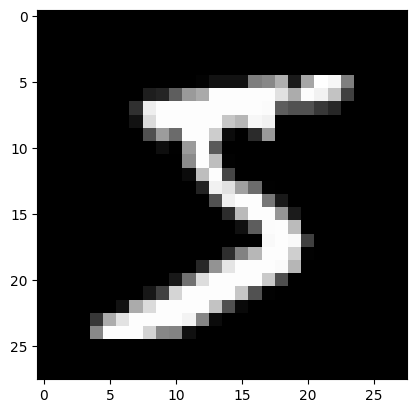

In [5]:
# отобразим одну картинку
print(train_dataset.targets[0])
plt.imshow(train_dataset.data[0].numpy(), cmap='gray')
plt.show()

tensor(7)


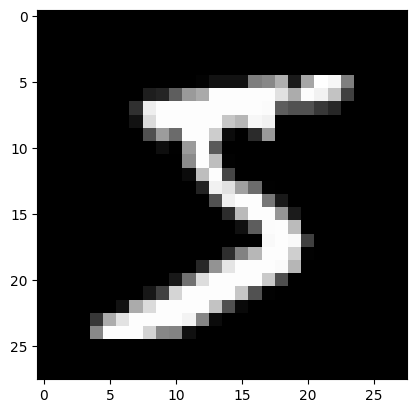

In [6]:
# отобразим одну картинку
print(test_dataset.targets[0])
plt.imshow(train_dataset.data[0].numpy(), cmap='gray')
plt.show()

In [11]:
# обучим сеть
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [13]:
# Создадим data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):  # Используем train_loader вместо train_dataset
        # получим входные данные
        inputs, labels = data


        optimizer.zero_grad()

        # вперед + назад + оптимизировать
        outputs = net(inputs)
        loss = criterion(outputs, labels)  # превращаем в тензор
        loss.backward()
        optimizer.step()

        # печать статистики
        running_loss += loss.item()
        if i % 200 == 199:    # печатаем каждые 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 1.554
[1,   400] loss: 0.321
[1,   600] loss: 0.186
[1,   800] loss: 0.162
[1,  1000] loss: 0.147
[1,  1200] loss: 0.112
[1,  1400] loss: 0.098
[1,  1600] loss: 0.098
[1,  1800] loss: 0.079
[2,   200] loss: 0.076
[2,   400] loss: 0.081
[2,   600] loss: 0.072
[2,   800] loss: 0.064
[2,  1000] loss: 0.064
[2,  1200] loss: 0.074
[2,  1400] loss: 0.057
[2,  1600] loss: 0.069
[2,  1800] loss: 0.058
Finished Training


In [15]:
# тестирование
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [17]:
# предсказание
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 97 %
Accuracy of     4 : 99 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 95 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %


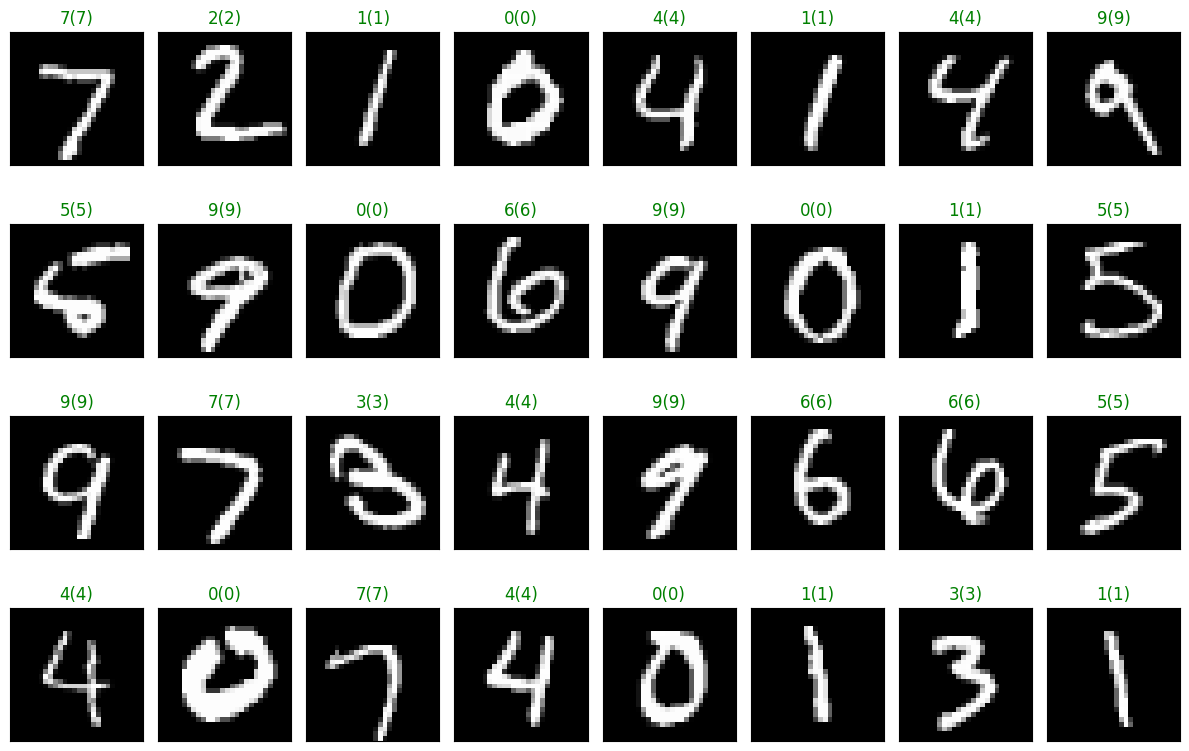


Всего ошибок: 164
Примеры ошибочных классификаций:


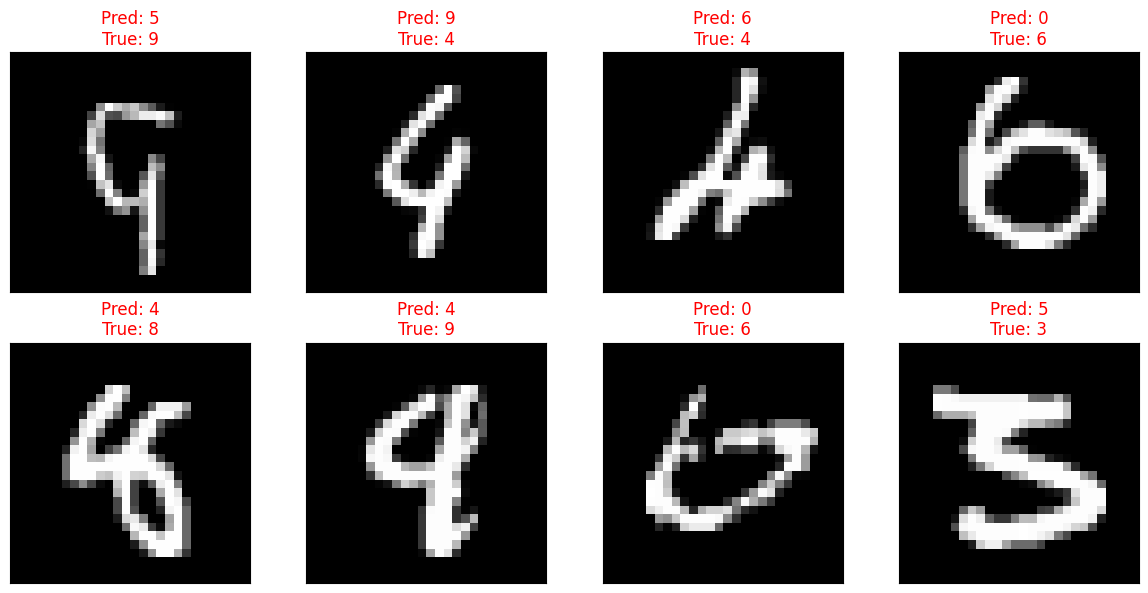

In [19]:
# Визуализация предсказаний
# Возьмем часть тестовых данных
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Получим предсказания
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Подготовка к визуализации
fig = plt.figure(figsize=(12, 8))
n_rows = 4
n_cols = 8

# Выведем 32 изображения с предсказаниями
for idx in np.arange(n_rows * n_cols):
    ax = fig.add_subplot(n_rows, n_cols, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].squeeze(), cmap='gray')

    # Установим цвет в зависимости от правильности предсказания
    color = 'green' if predicted[idx] == labels[idx] else 'red'

    ax.set_title(f"{predicted[idx].item()}({labels[idx].item()})", color=color)

plt.tight_layout()
plt.show()

# Дополнительная статистика по ошибкам
incorrect = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                incorrect.append((images[i], predicted[i], labels[i]))

# Выведем примеры ошибочных предсказаний
print(f"\nВсего ошибок: {len(incorrect)}")
print("Примеры ошибочных классификаций:")

fig = plt.figure(figsize=(12, 6))
for i in range(8):
    if i < len(incorrect):
        ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
        img, pred, true = incorrect[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Pred: {pred}\nTrue: {true}", color='red')
plt.tight_layout()
plt.show()

## Возьмите какую-нибудь картинку из mnist’а

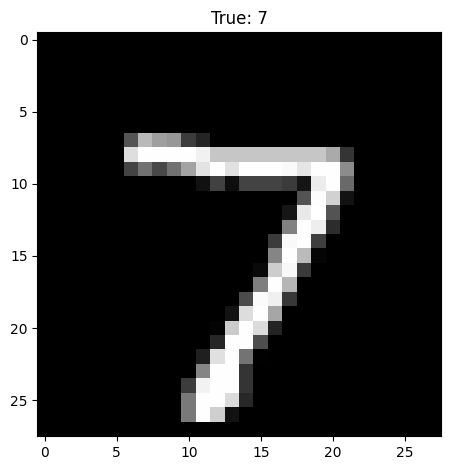

In [205]:
# возьмем картинку из тестового набора
dataiter = iter(test_loader)
images, labels = next(dataiter)

# визуализируем одну картинку из набора
idx = 0
ax = plt.subplot(1, 1, 1)
ax.imshow(images[idx].squeeze(), cmap='gray')
ax.set_title(f"True: {labels[idx]}")
plt.tight_layout()
plt.show()

## Обучите шум, который при добавлении к оригинальной картинке, заставит её ошибаться в пользу другого класса

Попытка 1

In [206]:
# Создадим шумовой тензор, который будем оптимизировать
noise = torch.zeros_like(image, requires_grad=True)

# Оптимизатор для шума
noise_optimizer = optim.Adam([noise], lr=learning_rate)

In [207]:
# Целевой класс для ошибочной классификации (выберем любой другой класс)
target_class = (true_label + 1) % 10  # Просто следующий класс по модулю 10

In [208]:
# Параметры атаки
epsilon = 0.9  # Максимальная величина шума
learning_rate = 0.02
num_steps = 600

In [209]:
# Функция для вычисления уверенности модели
def get_confidence(output, target):
    return F.softmax(output, 1)[0][target].item()

for step in range(num_steps):
    noise_optimizer.zero_grad()

    # Применяем шум с ограничением
    perturbed_image = torch.clamp(image + noise, 0, 1)
    output = net(perturbed_image)

    # Целевая функция:
    # 1) Увеличиваем вероятность целевого класса
    # 2) Уменьшаем вероятность исходного класса
    # 3) Регуляризация шума
    loss = (-F.cross_entropy(output, torch.tensor([target_class])) +
            F.cross_entropy(output, torch.tensor([true_label])) +
            0.01 * torch.norm(noise))

    loss.backward()
    noise_optimizer.step()

    # Ограничение величины шума
    noise.data = torch.clamp(noise.data, -epsilon, epsilon)

    if step % 40 == 0:
        with torch.no_grad():
            perturbed = torch.clamp(image + noise, 0, 1)
            output = net(perturbed)
            _, pred = torch.max(output, 1)
            conf = get_confidence(output, pred)
            print(f"Step {step}: Pred {pred.item()} (conf: {conf:.2f}), "
                  f"Target prob: {get_confidence(output, target_class):.2f}")

Step 0: Pred 7 (conf: 1.00), Target prob: 0.00
Step 40: Pred 7 (conf: 1.00), Target prob: 0.00
Step 80: Pred 7 (conf: 1.00), Target prob: 0.00
Step 120: Pred 7 (conf: 1.00), Target prob: 0.00
Step 160: Pred 7 (conf: 1.00), Target prob: 0.00
Step 200: Pred 7 (conf: 1.00), Target prob: 0.00
Step 240: Pred 7 (conf: 1.00), Target prob: 0.00
Step 280: Pred 7 (conf: 1.00), Target prob: 0.00
Step 320: Pred 7 (conf: 1.00), Target prob: 0.00
Step 360: Pred 7 (conf: 1.00), Target prob: 0.00
Step 400: Pred 7 (conf: 1.00), Target prob: 0.00
Step 440: Pred 7 (conf: 1.00), Target prob: 0.00
Step 480: Pred 7 (conf: 1.00), Target prob: 0.00
Step 520: Pred 7 (conf: 1.00), Target prob: 0.00
Step 560: Pred 7 (conf: 1.00), Target prob: 0.00


In [210]:
# Финальное атакованное изображение
perturbed_image = image + noise
perturbed_image = torch.clamp(perturbed_image, 0, 1)

In [211]:
# Финальные результаты
perturbed_image = torch.clamp(image + noise, 0, 1)

with torch.no_grad():
    output = net(perturbed_image)
    _, pred = torch.max(output, 1)
    conf = get_confidence(output, pred)
    target_conf = get_confidence(output, target_class)

    print("\nFinal results:")
    print(f"Original prediction: {true_label}")
    print(f"Perturbed prediction: {pred.item()} (confidence: {conf:.2f})")
    print(f"Target class {target_class} confidence: {target_conf:.2f}")


Final results:
Original prediction: 7
Perturbed prediction: 7 (confidence: 1.00)
Target class 8 confidence: 0.00


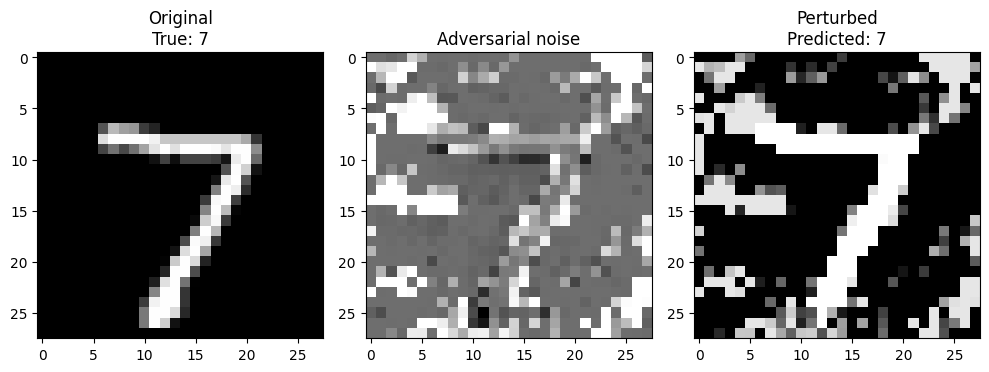

In [212]:
# Визуализация
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image.squeeze().detach().numpy(), cmap='gray')  # Добавили .detach()
plt.title(f"Original\nTrue: {true_label}")

plt.subplot(1, 3, 2)
plt.imshow(noise.squeeze().detach().numpy(), cmap='gray')  # Добавили .detach()
plt.title("Adversarial noise")

plt.subplot(1, 3, 3)
plt.imshow(perturbed_image.squeeze().detach().numpy(), cmap='gray')  # Добавили .detach()
plt.title(f"Perturbed\nPredicted: {pred_label}")

plt.tight_layout()
plt.show()

Модель не ошибается

Попытка 2

In [213]:
# Ультимативная адверсариальная атака
def strong_attack(model, image, true_label, target_label=None,
                 eps=0.5, alpha=0.1, iters=500, restarts=5):
    """
    Мощная атака с несколькими рестартами и комбинированными методами
    """
    best_perturbation = None
    best_confidence = -1

    for _ in range(restarts):
        # Инициализация с случайного шума
        noise = torch.randn_like(image) * eps
        noise = torch.clamp(noise, -eps, eps)
        noise.requires_grad_(True)

        # Оптимизатор с импульсом
        optimizer = optim.SGD([noise], lr=alpha, momentum=0.9)

        for _ in range(iters):
            perturbed = torch.clamp(image + noise, 0, 1)
            outputs = model(perturbed)

            # Комбинированная функция потерь
            if target_label is not None:
                # Targeted: увеличиваем целевую уверенность и уменьшаем исходную
                loss = (F.cross_entropy(outputs, torch.tensor([true_label])) -
                       F.cross_entropy(outputs, torch.tensor([target_label])))
            else:
                # Untargeted: просто увеличиваем потерю
                loss = -F.cross_entropy(outputs, torch.tensor([true_label]))

            # Регуляризация для более естественного шума
            loss += 0.1 * torch.norm(noise, p=2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Проекция на ε-шар
            noise.data = torch.clamp(noise.data, -eps, eps)
            noise.data = torch.clamp(image + noise.data, 0, 1) - image

        # Выбираем лучшую атаку
        with torch.no_grad():
            perturbed = torch.clamp(image + noise, 0, 1)
            outputs = model(perturbed)
            conf = F.softmax(outputs, 1)[0][target_label if target_label is not None else true_label].item()

            if conf > best_confidence:
                best_confidence = conf
                best_perturbation = perturbed.clone()

    return best_perturbation

In [214]:
# Выбираем сложный пример (где модель менее уверена)
with torch.no_grad():
    confidences = []
    for i, (img, label) in enumerate(zip(images[:100], labels[:100])):
        output = net(img.unsqueeze(0))
        conf = F.softmax(output, 1)[0][label].item()
        confidences.append((i, conf, img, label))

# Берем изображение с наименьшей уверенностью
confidences.sort(key=lambda x: x[1])
weak_idx, weak_conf, weak_img, weak_label = confidences[0]
weak_img = weak_img.unsqueeze(0)  # Add batch dimension

print(f"Selected image with lowest confidence: {weak_label} (conf: {weak_conf:.2f})")

Selected image with lowest confidence: 9 (conf: 0.98)


In [215]:
# Параметры супер-атаки
target_class = (weak_label + 7) % 10  # Сложная цель
eps = 0.9  # Большой допустимый шум
alpha = 0.7  # Крупный шаг
iters = 700  # Много итераций
restarts = 5  # Несколько рестартов

In [216]:
# Запускаем атаку
perturbed_image = strong_attack(net, weak_img, weak_label,
                              target_label=target_class,
                              eps=eps, alpha=alpha,
                              iters=iters, restarts=restarts)

In [217]:
# Проверяем результат
with torch.no_grad():
    output = net(perturbed_image)
    _, pred = torch.max(output, 1)
    conf = F.softmax(output, 1)[0][pred].item()
    target_conf = F.softmax(output, 1)[0][target_class].item()

    print("\nAttack results:")
    print(f"Original label: {weak_label}")
    print(f"Predicted: {pred.item()} (confidence: {conf:.2f})")
    print(f"Target class {target_class} confidence: {target_conf:.2f}")



Attack results:
Original label: 9
Predicted: 9 (confidence: 1.00)
Target class 6 confidence: 0.00


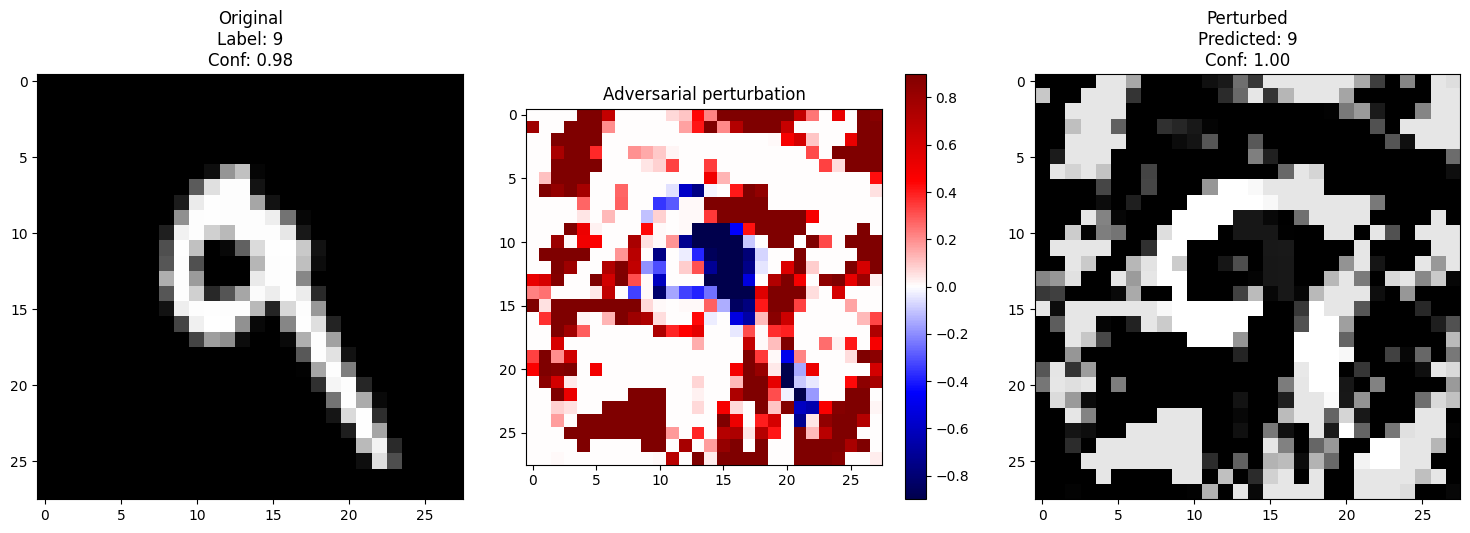

In [218]:
# Визуализация
plt.figure(figsize=(15, 5))

# Оригинал
plt.subplot(1, 3, 1)
plt.imshow(weak_img.squeeze().detach().numpy(), cmap='gray')
plt.title(f"Original\nLabel: {weak_label}\nConf: {weak_conf:.2f}")

# Разница
plt.subplot(1, 3, 2)
diff = (perturbed_image - weak_img).squeeze().detach().numpy()
plt.imshow(diff, cmap='seismic', vmin=-eps, vmax=eps)
plt.colorbar()
plt.title("Adversarial perturbation")

# Атакованное изображение
plt.subplot(1, 3, 3)
plt.imshow(perturbed_image.squeeze().detach().numpy(), cmap='gray')
plt.title(f"Perturbed\nPredicted: {pred.item()}\nConf: {conf:.2f}")

plt.tight_layout()
plt.show()

Где она тут увидела 9?

Попытка 3

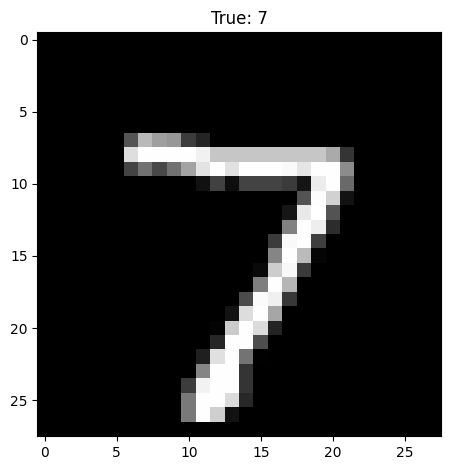

In [219]:
# возьмем картинку из тестового набора
dataiter = iter(test_loader)
images, labels = next(dataiter)

# визуализируем одну картинку из набора
idx = 0
ax = plt.subplot(1, 1, 1)
ax.imshow(images[idx].squeeze(), cmap='gray')
ax.set_title(f"True: {labels[idx]}")
plt.tight_layout()
plt.show()

In [220]:
# Усиленная PGD-атака
def pgd_attack(model, image, true_label, target_label=None,
               eps=0.3, alpha=0.01, iters=100, targeted=False):
    """
    PGD-атака на модель

    Параметры:
    - model: атакуемая модель
    - image: исходное изображение (1, 1, 28, 28)
    - true_label: истинная метка
    - target_label: целевая метка (для targeted атаки)
    - eps: максимальное изменение пикселей (L∞ норма)
    - alpha: размер шага
    - iters: количество итераций
    - targeted: если True — targeted атака, иначе — untargeted
    """
    # Инициализация шума
    noise = torch.zeros_like(image, requires_grad=True)

    for i in range(iters):
        perturbed_image = image + noise
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

        outputs = model(perturbed_image)
        loss = F.cross_entropy(outputs, torch.tensor([target_label if targeted else true_label]))

        if not targeted:
            loss = -loss  # Для untargeted атаки максимизируем потерю

        loss.backward()

        # Шаг атаки
        noise.data = noise.data + alpha * noise.grad.sign()
        # Проекция на ε-шар
        noise.data = torch.clamp(noise.data, -eps, eps)
        # Ограничение значений пикселей
        noise.data = torch.clamp(image + noise.data, 0, 1) - image

        noise.grad.zero_()

    return torch.clamp(image + noise.detach(), 0, 1)

In [221]:
# Параметры атаки
target_class = (true_label + 5) % 10  # Более сложная цель
eps = 0.9  # Максимальное изменение
alpha = 0.2  # Размер шага
iters = 600  # Итераци

In [222]:
# Запускаем атаку
perturbed_image = pgd_attack(net, image, true_label,
                           target_label=target_class,
                           eps=eps, alpha=alpha, iters=iters,
                           targeted=True)

In [223]:
# Проверяем результат
with torch.no_grad():
    output = net(perturbed_image)
    _, pred = torch.max(output, 1)
    conf = F.softmax(output, 1)[0][pred].item()
    target_conf = F.softmax(output, 1)[0][target_class].item()

    print("\nAttack results:")
    print(f"Original label: {true_label}")
    print(f"Predicted: {pred.item()} (confidence: {conf:.2f})")
    print(f"Target class {target_class} confidence: {target_conf:.2f}")


Attack results:
Original label: 7
Predicted: 5 (confidence: 1.00)
Target class 2 confidence: 0.00


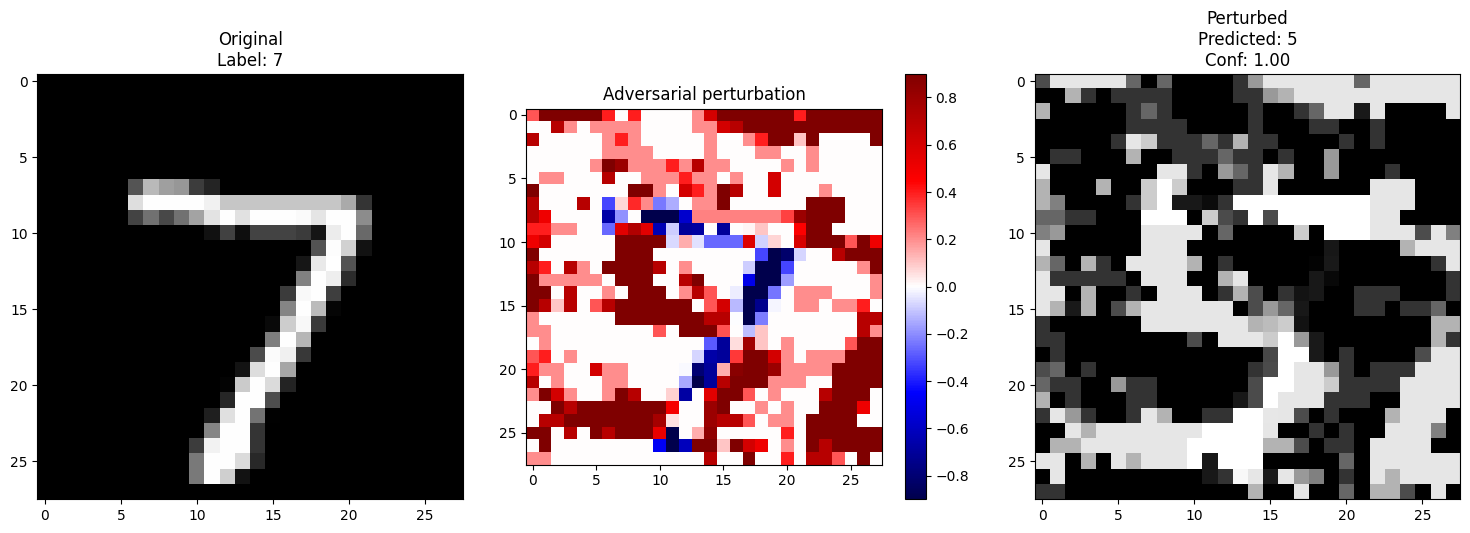

In [224]:
# Визуализация
plt.figure(figsize=(15, 5))

# Оригинал
plt.subplot(1, 3, 1)
plt.imshow(image.squeeze().detach().numpy(), cmap='gray')
plt.title(f"Original\nLabel: {true_label}")

# Разница
plt.subplot(1, 3, 2)
diff = (perturbed_image - image).squeeze().detach().numpy()
plt.imshow(diff, cmap='seismic', vmin=-eps, vmax=eps)
plt.colorbar()
plt.title("Adversarial perturbation")

# Атакованное изображение
plt.subplot(1, 3, 3)
plt.imshow(perturbed_image.squeeze().detach().numpy(), cmap='gray')
plt.title(f"Perturbed\nPredicted: {pred.item()}\nConf: {conf:.2f}")

plt.tight_layout()
plt.show()

Ура! Модель ошиблась

Выводы:
1. Обучена сеть LeNet на датасете MNIST
2. Обучен шум, который при добавлении к оригинальной картинке, заставил её ошибаться в пользу другого класса
3. Модель LeNet оказалась довольно устойчивой к различным шумам и в итоге понадобились три попытки для для того, чтобы заставить модель ошибаться